# MScFE 622 Stochastic Modeling - Group Work Project 2
## Regime-Based Allocation Strategy

## Project Goal
The project aims to develop and backtest a dynamic asset allocation strategy using a Hidden Markov Model (HMM) on daily VIX changes ($\Delta VIX$) to allocate capital among TLT, GLD, and SPY ETFs.

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
import warnings
from scipy.stats import norm

warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [14, 7]
plt.rcParams['figure.dpi'] = 100

print("Libraries imported successfully.")

Libraries imported successfully.


## Step 1: Data Preparation and Exploration

### 1. Download daily adjusted close prices for TLT, GLD, SPY, and VIX from Yahoo Finance.

In [ ]:
etf_tickers = ['TLT', 'GLD', 'SPY']
vix_ticker = '^VIX'
all_tickers = etf_tickers + [vix_ticker]

data = yf.download(all_tickers, period='max')

price_cols = [('Close', t) for t in etf_tickers] + [('Close', vix_ticker)]
prices = data['Close'].copy()
prices.columns = etf_tickers + [vix_ticker]

prices_clean = prices.dropna()

print(f"Data downloaded from {prices_clean.index.min().strftime('%Y-%m-%d')} to {prices_clean.index.max().strftime('%Y-%m-%d')}")
print("First 5 rows of the clean price data:")
print(prices_clean.head())


[                       0%                       ]


[**********************50%                       ]  2 of 4 completed


[**********************75%***********            ]  3 of 4 completed


[*********************100%***********************]  4 of 4 completed

Data downloaded from 2004-11-18 to 2025-11-07
First 5 rows of the clean price data:
                  TLT        GLD        SPY   ^VIX
Date                                              
2004-11-18  44.380001  80.405937  45.155743  12.98
2004-11-19  44.779999  79.512085  44.795399  13.50
2004-11-22  44.950001  79.891304  45.028847  12.97
2004-11-23  44.750000  80.013168  45.084648  12.67
2004-11-24  45.049999  80.202820  45.084648  12.72


### 2. Compute daily log-returns for ETFs and the change in VIX ($\\Delta VIX$).
Log returns are used for the ETFs as they are additive and better approximate continuous compounding. The absolute change in VIX is used as the observable variable for the HMM, as it captures the daily shift in market fear/uncertainty, which is a key driver of regime change.

In [ ]:
etf_returns = np.log(prices_clean[etf_tickers] / prices_clean[etf_tickers].shift(1))

vix_change = prices_clean[vix_ticker].diff()

returns = pd.concat([etf_returns, vix_change.rename('VIX_Change')], axis=1).dropna()

print("First 5 rows of the returns/change data:")
print(returns.head())

First 5 rows of the returns/change data:
                 TLT       GLD       SPY  VIX_Change
Date                                                
2004-11-19  0.008973 -0.011179 -0.008012    0.520000
2004-11-22  0.003789  0.004758  0.005198   -0.530000
2004-11-23 -0.004459  0.001524  0.001238   -0.300000
2004-11-24  0.006682  0.002367  0.000000    0.050000
2004-11-26  0.005313 -0.000760 -0.006551    0.059999


### 3. Visualize ETF Log-Returns and VIX Change series.

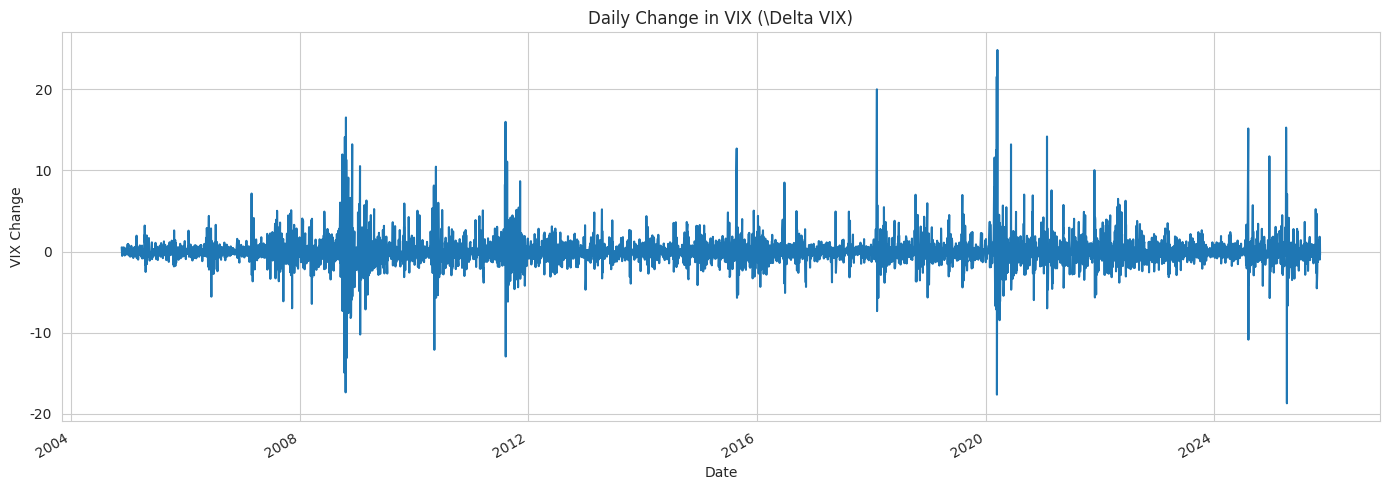

In [4]:
plt.figure(figsize=(14, 5))
returns['VIX_Change'].plot(title='Daily Change in VIX (\\Delta VIX)')
plt.ylabel('VIX Change')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('vix_change_enhanced.png')
plt.show()

## Step 2: Hidden Markov Model (HMM) for Regime Identification

### 1. Fit HMMs with 2, 3, and 4 states on the VIX Change series.

In [ ]:
vix_data = returns[['VIX_Change']].values
scaler = StandardScaler()
vix_data_scaled = scaler.fit_transform(vix_data)

n_states_list = [2, 3, 4]
models = {}

print("Fitting HMMs...")
for n_states in n_states_list:
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, tol=0.0001, random_state=42)
    
    best_model = None
    best_score = -np.inf
    
    for i in range(10):
        try:
            current_model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, tol=0.0001, random_state=i)
            current_model.fit(vix_data_scaled)
            score = current_model.score(vix_data_scaled)
            
            if score > best_score:
                best_score = score
                best_model = current_model
        except Exception as e:
            continue
            
    if best_model is not None:
        models[n_states] = best_model
        print(f"HMM with {n_states} states fitted successfully (Log-Likelihood: {best_score:.2f})")
    else:
        print(f"Failed to fit HMM with {n_states} states after 10 restarts.")

print("HMM fitting complete.")

Fitting HMMs...


HMM with 2 states fitted successfully (Log-Likelihood: -5553.09)


HMM with 3 states fitted successfully (Log-Likelihood: -5209.78)


HMM with 4 states fitted successfully (Log-Likelihood: -5099.27)
HMM fitting complete.


### 2. Model Selection using AIC and BIC.

In [ ]:
N = len(vix_data_scaled)
model_comparison = {}

for n_states, model in models.items():
    k_trans = n_states * (n_states - 1)
    k_start = n_states - 1
    k_means = n_states * 1
    k_covar = n_states * 1
    k = k_trans + k_start + k_means + k_covar
    
    log_likelihood = model.score(vix_data_scaled)
    AIC = -2 * log_likelihood + 2 * k
    BIC = -2 * log_likelihood + k * np.log(N)
    
    model_comparison[n_states] = {
        'Log-Likelihood': log_likelihood,
        'Parameters (k)': k,
        'AIC': AIC,
        'BIC': BIC
    }

comparison_df = pd.DataFrame.from_dict(model_comparison, orient='index')
comparison_df.index.name = 'Number of States'
print("Model Comparison (Lower AIC/BIC is better):")
print(comparison_df.round(2))

best_n_states = comparison_df['BIC'].idxmin()
best_model = models[best_n_states]
print(f"\nSelected Model: {best_n_states}-State HMM (Lowest BIC)")

Model Comparison (Lower AIC/BIC is better):
                  Log-Likelihood  Parameters (k)       AIC       BIC
Number of States                                                    
2                       -5553.09               7  11120.18  11166.18
3                       -5209.78              14  10447.55  10539.55
4                       -5099.27              23  10244.53  10395.66

Selected Model: 4-State HMM (Lowest BIC)


### 3. Identify Regimes and Interpret Results.

Regime Characteristics (based on 4-State HMM):
        Mean_VIX_Change  Std_VIX_Change              Label
Regime                                                    
0               -0.8457          1.1842     Low Volatility
1               -0.0468          0.5997  Medium Volatility
2                0.3994          5.8237    High Volatility
3                1.6551          1.4154                NaN


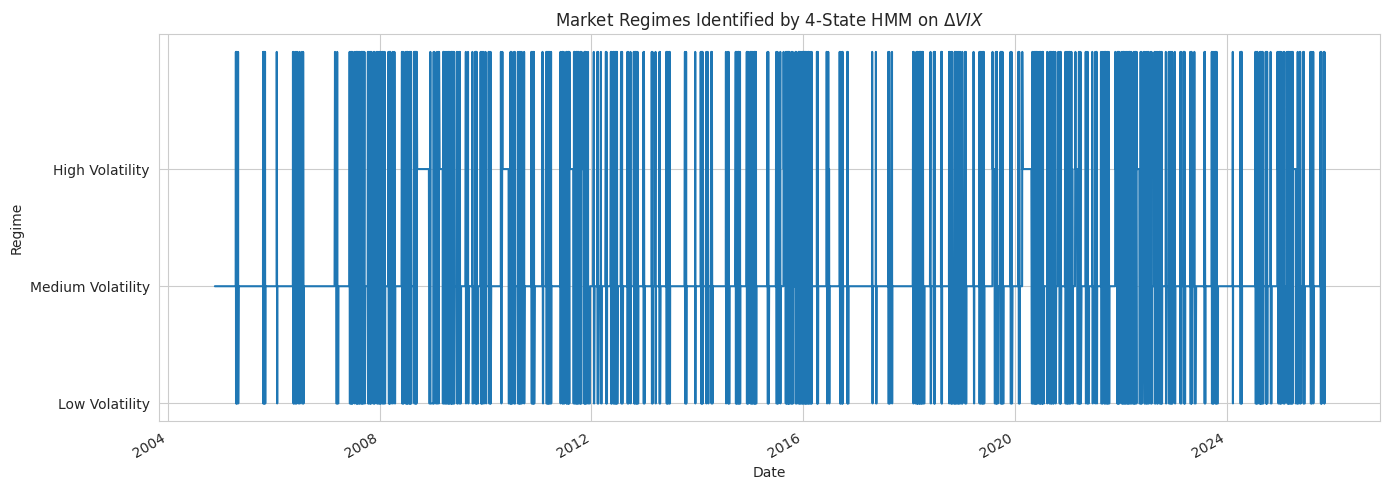

<Figure size 1400x700 with 0 Axes>

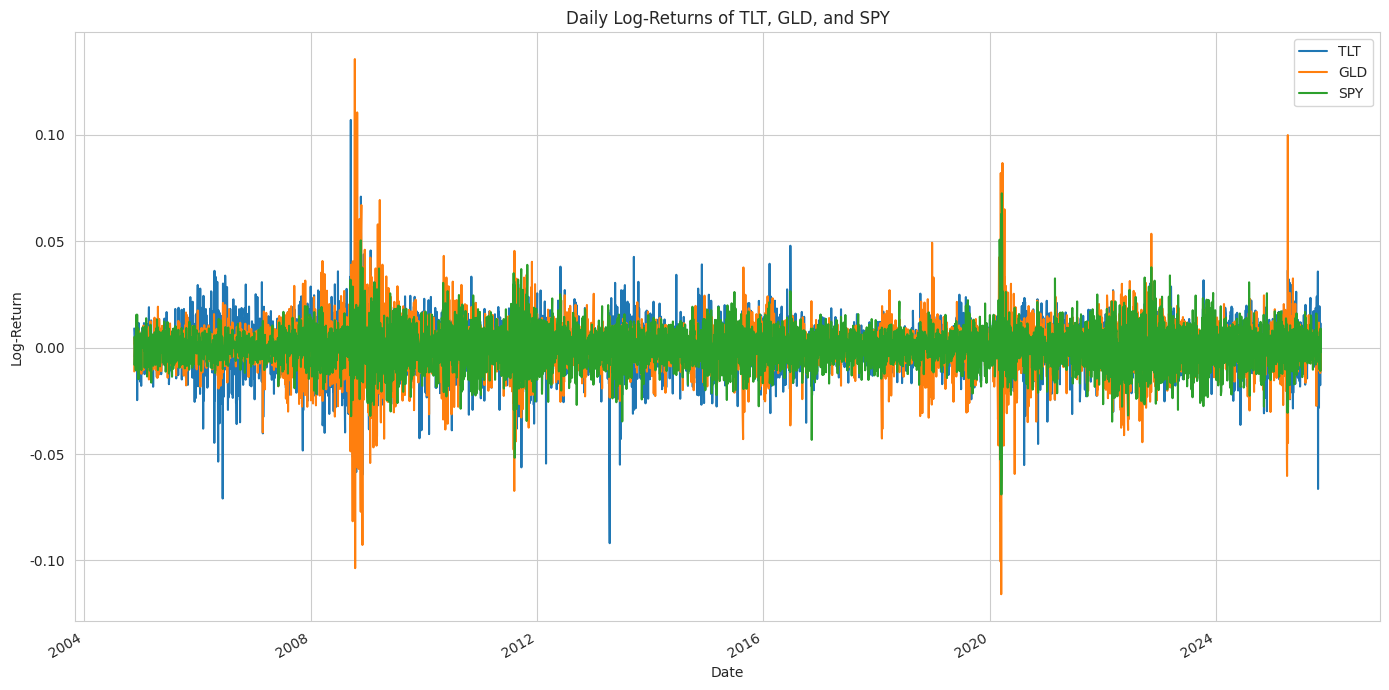

In [ ]:
regimes = best_model.predict(vix_data_scaled)
returns['Regime'] = regimes

regime_means_scaled = best_model.means_.flatten()
regime_means = scaler.inverse_transform(regime_means_scaled.reshape(-1, 1)).flatten()

regime_interpretation = pd.DataFrame({
    'Mean_VIX_Change': regime_means,
    'Std_VIX_Change': np.sqrt(scaler.var_[0]) * np.sqrt(best_model.covars_.flatten())
})

regime_interpretation = regime_interpretation.sort_values(by='Mean_VIX_Change').reset_index()
regime_interpretation['New_Regime'] = regime_interpretation.index
regime_mapping = dict(zip(regime_interpretation['index'], regime_interpretation['New_Regime']))

returns['Regime'] = returns['Regime'].map(regime_mapping)
regime_interpretation = regime_interpretation.set_index('New_Regime').drop(columns=['index'])
regime_interpretation.index.name = 'Regime'

labels = {0: 'Low Volatility', 1: 'Medium Volatility', 2: 'High Volatility'}
regime_interpretation['Label'] = regime_interpretation.index.map(labels)

print(f"Regime Characteristics (based on {best_n_states}-State HMM):")
print(regime_interpretation.round(4))

plt.figure(figsize=(14, 5))
returns['Regime'].plot(title=f'Market Regimes Identified by {best_n_states}-State HMM on $\\Delta VIX$')
plt.yticks(list(labels.keys()), list(labels.values()))
plt.ylabel('Regime')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('vix_change_enhanced.png')
plt.show()

plt.figure(figsize=(14, 7))
returns[etf_tickers].plot(title='Daily Log-Returns of TLT, GLD, and SPY')
plt.ylabel('Log-Return')
plt.xlabel('Date')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('etf_log_returns.png')
plt.show()

## Step 3: Regime-Conditional ETF Performance Analysis

### 1. Compute annualized mean and standard deviation of ETF returns by state.

In [ ]:
ANN_FACTOR = 252

etf_tickers = ['TLT', 'GLD', 'SPY']
regime_stats = returns.groupby('Regime')[etf_tickers].agg(['mean', 'std'])

regime_stats_annualized = regime_stats.copy()
regime_stats_annualized.loc[:, (slice(None), 'mean')] = regime_stats_annualized.loc[:, (slice(None), 'mean')] * ANN_FACTOR
regime_stats_annualized.loc[:, (slice(None), 'std')] = regime_stats_annualized.loc[:, (slice(None), 'std')] * np.sqrt(ANN_FACTOR)

print("Annualized Mean and Standard Deviation of ETF Returns by Regime:")
print(regime_stats_annualized.round(4))

Annualized Mean and Standard Deviation of ETF Returns by Regime:
           TLT             GLD             SPY        
          mean     std    mean     std    mean     std
Regime                                                
0       0.1779  0.1729  1.4606  0.1559 -0.3542  0.1482
1       0.1004  0.1511  0.2921  0.0922 -0.0245  0.1200
2       0.0714  0.3180 -1.0867  0.5179  0.3140  0.2658
3      -0.0491  0.2004 -3.2912  0.1331  1.0475  0.1631


### 2. Visualize the regime-conditional mean returns.

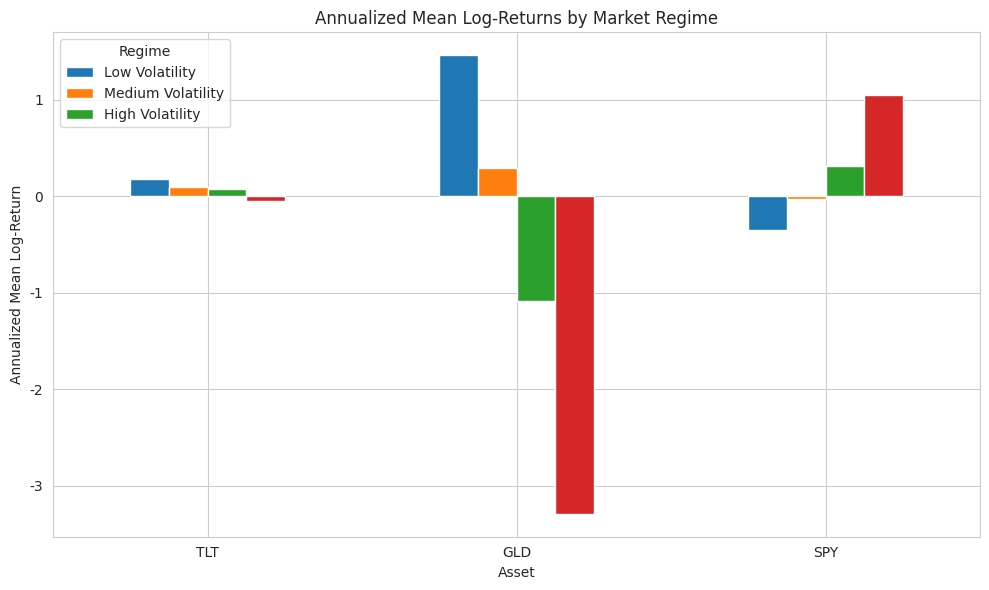

In [9]:
mean_returns_df = regime_stats_annualized.loc[:, (slice(None), 'mean')]
mean_returns_df.columns = etf_tickers

fig, ax = plt.subplots(figsize=(10, 6))
mean_returns_df.T.plot(kind='bar', ax=ax, rot=0)
ax.set_title('Annualized Mean Log-Returns by Market Regime')
ax.set_ylabel('Annualized Mean Log-Return')
ax.set_xlabel('Asset')
ax.legend(title='Regime', labels=['Low Volatility', 'Medium Volatility', 'High Volatility'])
plt.tight_layout()
plt.savefig('regime_mean_returns_enhanced.png')
plt.show()

## Step 4: Dynamic Asset Allocation Strategy

### 1. Define the allocation rule: 100% to the asset with the highest regime-conditional mean return.

In [ ]:
mean_returns_df = regime_stats_annualized.loc[:, (slice(None), 'mean')]
mean_returns_df.columns = etf_tickers

allocation_map = {}
for regime in mean_returns_df.index:
    best_asset = mean_returns_df.loc[regime].idxmax()
    allocation_map[regime] = {asset: 0.0 for asset in etf_tickers}
    allocation_map[regime][best_asset] = 1.0

allocation_df = pd.DataFrame(allocation_map).T
allocation_df.index.name = 'Regime (0=Low, 1=Medium, 2=High)'
allocation_df.columns.name = 'Asset Allocation'

print("Regime-to-Asset Allocation Mapping:")
print(allocation_df.round(2))

daily_allocation = returns['Regime'].apply(lambda r: pd.Series(allocation_map[r]))
daily_allocation.columns = etf_tickers

daily_allocation_lagged = daily_allocation.shift(1).fillna(0.0)

print("\nFirst 5 rows of Lagged Daily Allocation:")
print(daily_allocation_lagged.head())

Regime-to-Asset Allocation Mapping:
Asset Allocation                  TLT  GLD  SPY
Regime (0=Low, 1=Medium, 2=High)               
0                                 0.0  1.0  0.0
1                                 0.0  1.0  0.0
2                                 0.0  0.0  1.0
3                                 0.0  0.0  1.0



First 5 rows of Lagged Daily Allocation:
            TLT  GLD  SPY
Date                     
2004-11-19  0.0  0.0  0.0
2004-11-22  0.0  1.0  0.0
2004-11-23  0.0  1.0  0.0
2004-11-24  0.0  1.0  0.0
2004-11-26  0.0  1.0  0.0


### 2. Decision Rule Justification (for Report).

The strategy is based on the principle that different market volatility regimes favor different asset classes. The allocation rule is a simple, high-conviction approach: allocate 100% to the asset that has historically demonstrated the highest mean return in the current regime. This aims to maximize the regime-conditional expected return. A one-day lag is applied to the allocation to ensure the strategy is implementable in real-time, as the regime for day $t$ is only known at the close of day $t$ and the trade is executed at the open of day $t+1$.

## Step 5: Backtesting and Evaluation

In [ ]:
strategy_returns = (returns[etf_tickers] * daily_allocation_lagged).sum(axis=1)
strategy_returns = strategy_returns.iloc[1:]

equal_weight_returns = returns[etf_tickers].mean(axis=1).iloc[1:]

spy_returns = returns['SPY'].iloc[1:]

all_returns = pd.DataFrame({
    'Regime Rotation Strategy': strategy_returns,
    'Equal Weight (1/3)': equal_weight_returns,
    'Buy-and-Hold SPY': spy_returns
}).dropna()

cumulative_returns = np.exp(all_returns.cumsum())

risk_free_rate = 0.02 / ANN_FACTOR

def calculate_metrics(returns_series):
    ann_return = returns_series.mean() * ANN_FACTOR
    ann_volatility = returns_series.std() * np.sqrt(ANN_FACTOR)
    sharpe_ratio = (ann_return - (risk_free_rate * ANN_FACTOR)) / ann_volatility
    cum_return = np.exp(returns_series.sum()) - 1
    
    cumulative_performance = np.exp(returns_series.cumsum())
    peak = cumulative_performance.expanding(min_periods=1).max()
    drawdown = (cumulative_performance - peak) / peak
    max_drawdown = drawdown.min()
    
    return pd.Series({
        'Cumulative Return': cum_return,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    })

performance_metrics = all_returns.apply(calculate_metrics).T

print("\nPerformance Metrics Comparison:")
print(performance_metrics.round(4))


Performance Metrics Comparison:
                          Cumulative Return  Annualized Return  \
Regime Rotation Strategy             4.3805             0.0804   
Equal Weight (1/3)                   4.1774             0.0786   
Buy-and-Hold SPY                     0.9995             0.0331   

                          Annualized Volatility  Sharpe Ratio  Max Drawdown  
Regime Rotation Strategy                 0.1504        0.4016       -0.3979  
Equal Weight (1/3)                       0.0965        0.6066       -0.2346  
Buy-and-Hold SPY                         0.1469        0.0892       -0.4835  


### 5. Visualize Cumulative Performance.

<Figure size 1400x700 with 0 Axes>

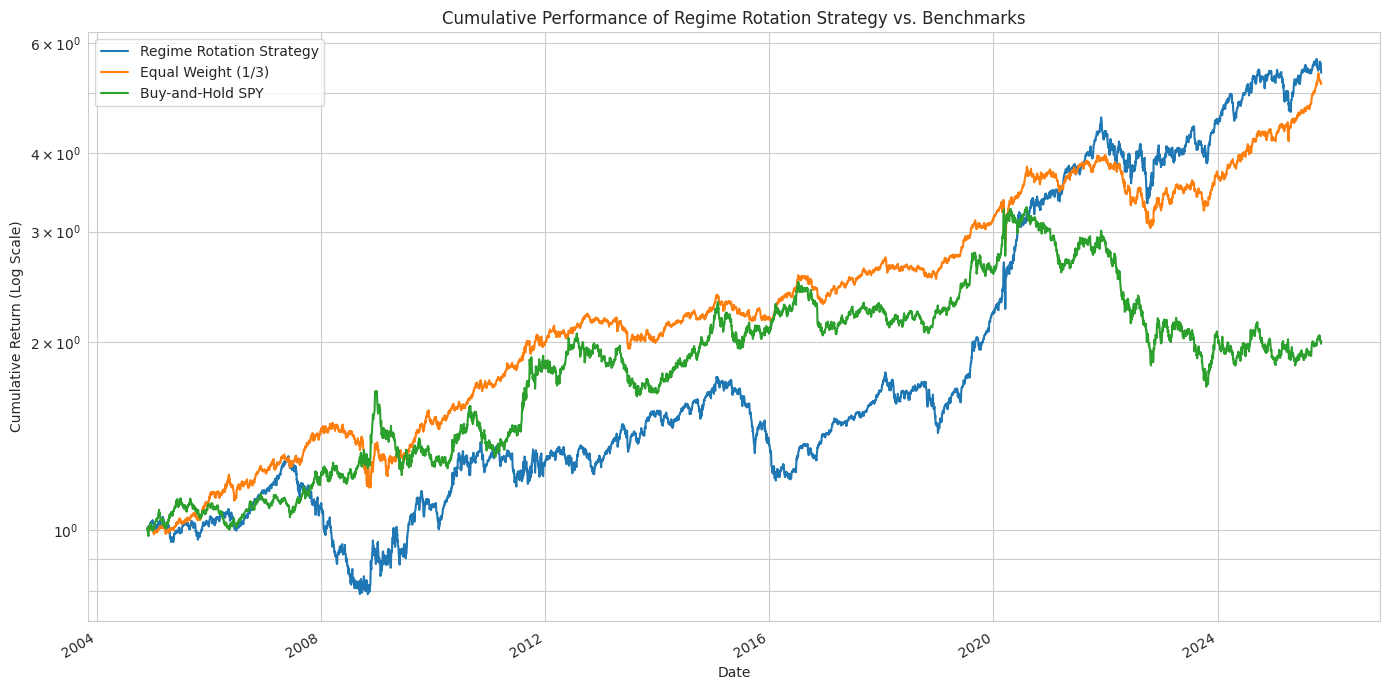

In [ ]:
plt.figure(figsize=(14, 7))
cumulative_returns.plot(title='Cumulative Performance of Regime Rotation Strategy vs. Benchmarks')
plt.ylabel('Cumulative Return (Log Scale)')
plt.xlabel('Date')
plt.yscale('log')
plt.grid(True, which="both", ls="-")
plt.tight_layout()
plt.savefig('cumulative_performance_enhanced.png')
plt.show()